###  Pizzeria's Data

In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])
web_logs.head(3)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7


web-logs — таблица с логами посещения сайта.

1. user_id — идентификатор пользователя;
2. page — какая страница сайта была открыта. Типы страниц:
    + m — страница с меню;
    + b  — страница с корзиной и подтверждением заказа;
    + p — страница с оплатой заказа;
3. date — дата открытия страницы;
4. load_time — время загрузки страницы в миллисекундах.

**Предполагается, что данные независимы**

Посмотрим, сколько данных нам потребуется, 
если мы захотим проводить тест в течение недели и хотим быть способны обнаружить эффект в 1%:

In [3]:
web_logs_hist = web_logs[
    (web_logs['date'] >= datetime(2022, 3, 22))
    & (web_logs['date'] < datetime(2022, 3, 29))
]
web_logs_hist.shape

(247163, 4)

In [6]:
# Calculating variance before dropping outliers

alpha = 0.05
beta = 0.2

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

eff = mean * 0.01
print(f"var is {std ** 2}")

# Calculating sample size
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

sample_size = get_sample_size_abs(eff, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

var is 12447.803325889607
sample_size = 355889


Нам требуется более 350 000 наблюдений, связанных с загрузкой страницы!
Можно ли оценить такой же эффект, но с меньшими затратами? 
Давайте посмотрим на распределение выборки


<Axes: >

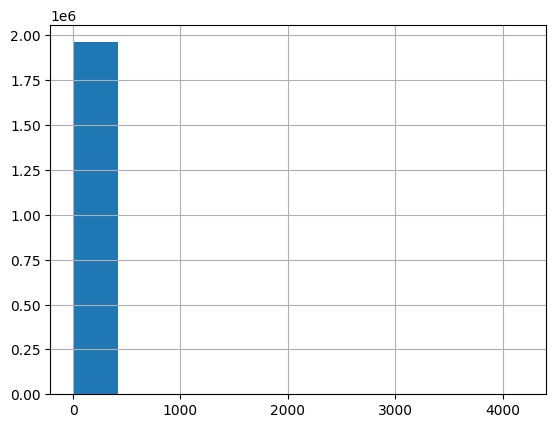

In [7]:
web_logs['load_time'].hist()

Мы видим, что бОльшая часть данных находится около нуля, но при этом есть огромные выбросы, 
которые могут сильно влиять на дисперсию данных. 
Давайте попробуем удалить выбросы и повторить оценку дизайна эксперимента:

<Axes: >

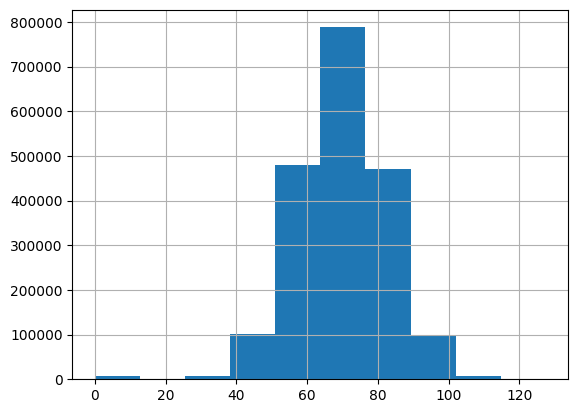

In [8]:
web_logs_filtered = web_logs[web_logs['load_time'] < 1000] 
web_logs_filtered['load_time'].hist()

In [10]:
alpha = 0.05
beta = 0.2

std = web_logs_filtered['load_time'].std()
print(f"Дисперсия(var) is {std ** 2}")

Дисперсия(var) is 162.03326010465977


In [11]:
sample_size = get_sample_size_abs(eff, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 4633


**Дисперсия упала более чем в 76 раз, что привело к падению необходимого размера выборки в 76 раз**. 
Таким образом, даже такие простые методы, как фильтрация выбросов, могут приводить к существенному 
снижению дисперсии при условии, что данная процедура значительно снижает дисперсию

### Удаление выбросов и оценка мощности тестов (Эффект в тестах: умножение на константу)

In [ ]:
# С одной стороны, при удалении выбросов снижается дисперсия, что приводит к увеличению чувствительности теста. 
# С другой стороны, при удалении выбросов уменьшается размер выборки, что приводит к уменьшению чувствительности.

# Сравним мощности тестов с разной долей удаляемых данных. 
# Используем данные о времени работы бэкенда 2022-04-13/2022-04-13T12_df_web_logs.csv в период с 2022-03-01 по 2022-03-08. 
# Уровень значимости — 0.05. Размеры групп — 1000 человек (размер выборок будет больше, 
# так как на одного человека приходится много значений). 
# Проверяем гипотезу о равенстве средних с помощью теста Стьюдента. 
# Ожидаемый эффект — увеличение времени обработки на 1%. 
# Эффект в синтетических А/В-тестах добавляем умножением на константу.

# 1. Удалить 0.02% выбросов;
# 2. Удалить 0.2% выбросов;
# 3. Удалить 2% выбросов;
# 4. Удалить 10% выбросов;
# 5. Удалить 20% выбросов.

# Удалить 2% выбросов означает, что нужно убрать по 1% минимальных и максимальных значений выборки. 
# То есть оставить значения, которые лежат между np.quantile(values, 0.01) и np.quantile(values, 0.99). 
# Квантили вычислять для каждой групп отдельно.

import os
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats

# URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/'
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_logs = read_database('2022-04-01T12_df_web_logs.csv')
df_logs['date'] = pd.to_datetime(df_logs['date'])

# df_logs = read_database('2022-04-13/2022-04-13T12_df_web_logs.csv')
# df_logs['date'] = pd.to_datetime(df_logs['date'])

begin_date = datetime(2022, 3, 1)
end_date = datetime(2022, 3, 8)
df_logs = df_logs[(df_logs['date']>=begin_date) & (df_logs['date'] < end_date)][['user_id', 'load_time']]
df_logs.head()

,user_id,load_time
885082,434cf2,69.8
885083,80fa93,86.3
885084,434cf2,58.0
885085,a0aaab,85.2
885086,a22f92,92.5


In [52]:
users = df_logs['user_id'].unique()
# user_list = np.random.choice(users, size=1000, replace=False)
# print(type(df_logs[df_logs['user_id'].isin(user_list)]['load_time'])) # Series
# print(type(df_logs[df_logs['user_id'].isin(user_list)]['load_time'].values)) # Array
# a = df_logs[df_logs['user_id'].isin(user_list)]['load_time'].values
# print(type(a))
# a[(a > np.quantile(a, 0.001)) & (a < np.quantile(a, 1-0.001))]

In [53]:
from tqdm.notebook import tqdm
# 1. Удалить 0.02% выбросов;
# 2. Удалить 0.2% выбросов;
# 3. Удалить 2% выбросов;
# 4. Удалить 10% выбросов;
# 5. Удалить 20% выбросов.

sample_size = 1000
effect = 0.01
alpha = 0.05
quantiles = [0.0001, 0.001, 0.01, 0.05, 0.1,] # 0.02, 0.2, 2, 10, 20 -> (% - доли)  0.0002, 0.002, 0.02, 0.1, 0.2 -> (x/2) с обеих сторон -> 0.0001, 0.001, 0.05, 0.1
quantile2errors = {q: [] for q in quantiles} # {0.0001: [], 0.001: []... }
for _ in tqdm(range(1000)):
    a_users, b_users = np.random.choice(users, size=(2, sample_size), replace=False)
    a_load_times = df_logs[df_logs['user_id'].isin(a_users)]['load_time'].values
    b_load_times = df_logs[df_logs['user_id'].isin(b_users)]['load_time'].values * (1 + effect)

    for q in quantiles:
        a_values_filtered = a_load_times[
            (a_load_times > np.quantile(a_load_times, q)) & 
            (a_load_times < np.quantile(a_load_times, 1-q))
        ]
        b_values_filtered = b_load_times[
            (b_load_times > np.quantile(b_load_times, q)) & 
            (b_load_times < np.quantile(b_load_times, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)


def process_results(quantile2errors):
    """Обрабатываем данные и выводим результат."""
    # список из элементов: номер варианта, квантиль, доля ошибок, список ошибок).
    data = [
        (idx+1, quantile, np.mean(errors), errors)
        for idx, (quantile, errors) in enumerate(quantile2errors.items())
    ]
    # сортируем по доле ошибок
    data.sort(key=lambda x: x[2])
    # проверим, что оценки мощности значимо отличаются друг от друга
    print(f'idx={data[0][0]} quantile={data[0][1]}, power={1-data[0][2]:0.3f}')
    for i in range(1, len(data)):
        pvalue = stats.ttest_ind(data[i][3], data[i-1][3]).pvalue
        if pvalue < 0.05:
            msg = f'pvalue={pvalue:0.4f}, оценка мощности значимо отличается от предыдущей'
        else:
            msg = f'pvalue={pvalue:0.4f}, оценка мощности не отличается значимо от предыдущей'
        print(f'idx={data[i][0]} quantile={data[i][1]}, power={1-data[i][2]:0.3f}, {msg}')
    print('answer:', ''.join([str(x[0]) for x in data]))

process_results(quantile2errors)

# idx=5 quantile=0.1, power=0.968
# idx=4 quantile=0.05, power=0.958, pvalue=0.0002, оценка мощности значимо отличается от предыдущей
# idx=3 quantile=0.01, power=0.933, pvalue=0.0000, оценка мощности значимо отличается от предыдущей
# idx=2 quantile=0.001, power=0.352, pvalue=0.0000, оценка мощности значимо отличается от предыдущей
# idx=1 quantile=0.0001, power=0.094, pvalue=0.0000, оценка мощности значимо отличается от предыдущей
# answer: 54321


  0%|          | 0/1000 [00:00<?, ?it/s]

idx=5 quantile=0.1, power=0.966
idx=4 quantile=0.05, power=0.954, pvalue=nan, оценка мощности не отличается значимо от предыдущей
idx=3 quantile=0.01, power=0.931, pvalue=nan, оценка мощности не отличается значимо от предыдущей
idx=2 quantile=0.001, power=0.321, pvalue=nan, оценка мощности не отличается значимо от предыдущей
idx=1 quantile=0.0001, power=0.074, pvalue=nan, оценка мощности не отличается значимо от предыдущей
answer: 54321


### Удаление выбросов и оценка мощности тестов (Эффект в тестах: добавление константы)

In [ ]:
# Выполним то же задание, изменив способ добавления эффекта. 
# Эффект в синтетических А/В-тестах добавляем добавлением константы к 1% данных.

from tqdm.notebook import tqdm
# 1. Удалить 0.02% выбросов;
# 2. Удалить 0.2% выбросов;
# 3. Удалить 2% выбросов;
# 4. Удалить 10% выбросов;
# 5. Удалить 20% выбросов.

sample_size = 1000
effect = 0.01
alpha = 0.05
quantiles = [0.0001, 0.001, 0.01, 0.05, 0.1,] # 0.02, 0.2, 2, 10, 20 -> (% - доли)  0.0002, 0.002, 0.02, 0.1, 0.2 -> (x/2) с обеих сторон -> 0.0001, 0.001, 0.05, 0.1
quantile2errors = {q: [] for q in quantiles} # {0.0001: [], 0.001: []... }
for _ in tqdm(range(1000)):
    a_users, b_users = np.random.choice(users, size=(2, sample_size), replace=False)
    a_load_times = df_logs[df_logs['user_id'].isin(a_users)]['load_time'].values
    b_load_times = df_logs[df_logs['user_id'].isin(b_users)]['load_time'].values
    b_mean = b_load_times.mean()
    indexes = np.random.choice(np.arange(len(b_load_times)), int(len(b_load_times)/100), False)  # int(len(b_load_times)/100) - 1% от общего кол-ва данных | np.arange(len(b_load_times)) - индексы
    b_load_times[indexes] += b_mean * effect * len(b_load_times) / len(indexes)


    for q in quantiles:
        a_values_filtered = a_load_times[
            (a_load_times > np.quantile(a_load_times, q)) & 
            (a_load_times < np.quantile(a_load_times, 1-q))
        ]
        b_values_filtered = b_load_times[
            (b_load_times > np.quantile(b_load_times, q)) & 
            (b_load_times < np.quantile(b_load_times, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)


def process_results(quantile2errors):
    """Обрабатываем данные и выводим результат."""
    # список из элементов: номер варианта, квантиль, доля ошибок, список ошибок).
    data = [
        (idx+1, quantile, np.mean(errors), errors)
        for idx, (quantile, errors) in enumerate(quantile2errors.items())
    ]
    # сортируем по доле ошибок
    data.sort(key=lambda x: x[2])
    # проверим, что оценки мощности значимо отличаются друг от друга
    print(f'idx={data[0][0]} quantile={data[0][1]}, power={1-data[0][2]:0.3f}')
    for i in range(1, len(data)):
        pvalue = stats.ttest_ind(data[i][3], data[i-1][3]).pvalue
        if pvalue < 0.05:
            msg = f'pvalue={pvalue:0.4f}, оценка мощности значимо отличается от предыдущей'
        else:
            msg = f'pvalue={pvalue:0.4f}, оценка мощности не отличается значимо от предыдущей'
        print(f'idx={data[i][0]} quantile={data[i][1]}, power={1-data[i][2]:0.3f}, {msg}')
    print('answer:', ''.join([str(x[0]) for x in data]))

process_results(quantile2errors)


  0%|          | 0/1000 [00:00<?, ?it/s]

idx=3 quantile=0.01, power=0.439
idx=2 quantile=0.001, power=0.342, pvalue=nan, оценка мощности не отличается значимо от предыдущей
idx=5 quantile=0.1, power=0.318, pvalue=nan, оценка мощности не отличается значимо от предыдущей
idx=4 quantile=0.05, power=0.298, pvalue=nan, оценка мощности не отличается значимо от предыдущей
idx=1 quantile=0.0001, power=0.083, pvalue=nan, оценка мощности не отличается значимо от предыдущей
answer: 32541
